# AI534 Implementation Assignment 2###

**Deadline**: Sunday, Oct. 27, by 11:59pm

**Submission**: Submit 1) your completed notebook in ipynb format, and 2) a PDF export of the completed notebook with outputs.

**Late Submission**: Please see the syllabus for the late submission policy.

In this assignment, we will implement and experiment with logistic regression with L2 and L1 regularization to predict whether a health insurance customer will purchase car insurance as well based on a set of features.

You may modify the starter code as you see fit, including changing the signatures of functions and adding/removing helper functions. However, please make sure that your TA can understand what you are doing and why.

Team : IA2 7

Members: Hyuntaek Oh, Woonki Kim

Email: ohhyun@oregonstate.edu, kimwoon@oregonstate.edu

First lets import the necessary packages.

In [ ]:
!pip install nbconvert > /dev/null 2>&1
!pip install pdfkit > /dev/null 2>&1
!apt-get install -y wkhtmltopdf > /dev/null 2>&1
import os
import pdfkit
import contextlib
import sys
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# add more imports if necessary

# Loading data and perform feature normalization for numerical features

---

On canvas, we have provided three different data files for this assignment: IA2-train.csv (for training), IA2-dev.csv(for validation) and IA2-train-noisy.csv (for noisy training). Download them and upload them to your google drive. Then mount the google drive from your google colab notebook:


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

train_path = '/content/gdrive/My Drive/AI534/IA2-train.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
val_path = '/content/gdrive/My Drive/AI534/IA2-dev.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
noisy_train_path = '/content/gdrive/My Drive/AI534/IA2-train-noisy.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


You have one additional preprocessing step to do, which is to perform feature normalization (z-score) for 3 numerical features ("Age", "Annual_Premium", "Vintage").

In [ ]:
# your code goes here

In [ ]:
#read data from path.
train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
noisy_train_data = pd.read_csv(noisy_train_path)

In [ ]:
#normalization function
def normalize_features(df):
    # Calculate the mean and standard deviation of the numerical features
    mean = df[['Age', 'Annual_Premium', 'Vintage']].mean()
    std = df[['Age', 'Annual_Premium', 'Vintage']].std()

    # Normalize the numerical features
    df[['Age', 'Annual_Premium', 'Vintage']] = (df[['Age', 'Annual_Premium', 'Vintage']] - mean) / std

    return df

In [ ]:
norm_train = normalize_features(train_data)
norm_val = normalize_features(val_data)
norm_nosiy = normalize_features(noisy_train_data)

# Part 1 (35 pts) Logstic regression with L2 (Ridge) regularization

For this part of the assignment, you will implement and experiment with Logistic regression with L2 regularization (Algorithm 1 in Assignment 2 Reference Information on canvas).


## Impelement Logistic regression with L2 regularization
As a recommendation, your implemented function should consider the following inputs:
1. The training data
2. The regularization parameter $\lambda$
3. The learning rate
4. Max iterations (recommend to start with 5000)
5. Threshold for change in loss (this will be used for early stopping: if the change in loss is less than the threshold, it is considered to have converged. Please use a threhold of $10^{-7}$. )

Your function should output the learned weight vector. But it is also a good idea to output the sequence of losses so that you can visualize the convergence process to ensure proper convergence. You should also implement a divergence detection, if the loss starts to diverge, terminate and raise an alarm.



In [ ]:
# Your code goes here
np.zeros(norm_train.shape[1]).shape

(198,)

In [ ]:
#Sigmoid function
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

#Loss function
def calculate_loss(X,y, weight,regularization_param):
  N = X.shape[0]
  y_pred = sigmoid(np.dot(X, weight))

  #loss = -np.mean(np.dot((np.dot(y , np.log(y_pred)) + (1 - y)) ,np.log(1 - y_pred)))
  loss = -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

  reg_loss = (regularization_param/2) * np.dot(weight.T, weight)

  return loss + reg_loss

In [ ]:
def logistic_regression(X, y, learning_rate, regularization_param, max_iterations, threshold):
    # Initialize weights
    N, d = X.shape
    weight = np.zeros(d)
    losses = []
    divergence_threshold = 100
    min_loss_change = 1e-4
    check_convergence = False
    decrement_param = 2

    # Gradient descent loop
    for it in range(max_iterations):
        # Calculate the gradient
        y_pred = sigmoid(np.dot(X, weight))
        #gradient
        gradient = (1/N) * np.dot(X.T, (y-y_pred))
        #L2 norm excluding w_0
        new_weight = weight + learning_rate * gradient
        new_weight[1:] -= learning_rate * regularization_param * new_weight[1:]

        # Calculate the loss
        loss = calculate_loss(X, y, weight, regularization_param)
        losses.append(loss)

        # Adjust learning rate based on loss behavior
        if it > 2:
          loss_diff = losses[-2] - losses[-1]

          # Check for divergence
          if loss_diff < 0:
            divergence_threshold -= 1


          # Stop if loss diverges too much
          if divergence_threshold == 0:
            break

        # Check for convergence
        if np.linalg.norm(new_weight - weight) < threshold:
          check_convergence = True
          print(f"Converged after {it + 1} iterations.")
          break

        weight = new_weight

    return weight, losses, check_convergence

##Experiment with different regularization parameters
For this part, you will need to run your L2 logistic regression algorithm on the training data with different regularization parameters $\lambda\in \{10^i: i\in[-5, 0]\}$. This is the minimim range of values required. Feel free to experiment with more extreme or in-between values to help you answer the questions.

**Learning Rate Tuning Guidelines:**
For different values of $\lambda$, you'll need to adjust the learning rate. I recommend starting with $\gamma = 1$ for very small $\lambda$s (e.g. $10^{-5}, 10^{-4}$). For moderately larger $\lambda$ values like $10^{-3}$, consider a smaller learning rate like $\gamma = 0.1$. As $\lambda$ increases further, you will need to continue decreasig the learning rate accordingly.
Note: You might wonder why larger $\lambda$ values require a smaller learning rate. This is because larger $\lambda$ values increase the strength of regularization, which in turn affects the gradient due to the larger penalty term (related to the regularization term). If the same learning rate is used, it can result in larger update steps due to the increased gradient magnitude, potentially leading to unstable training.

For each $\lambda$ value, you are required to run the logistic regression to convergence, record the resulting model (the weight vector), evaluate it on the training and validation data and record the accuracies.

In [ ]:
# Your code goes here

In [ ]:
x_train = norm_train.drop('Response', axis=1)
y_train = norm_train['Response']
x_val = norm_val.drop('Response', axis=1)
y_val = norm_val['Response']

In [ ]:
import sklearn.metrics as sklearn
from sklearn.metrics import accuracy_score

#measuring accuracy
def run_logistic_regression_L2(X_train, y_train, X_val, y_val,learning_rates, regularization_params):
    results = []

    for i, reg_param in enumerate(regularization_params):
        learning_rate = learning_rates[i]

        # Train the model
        weight, losses ,check_convergence= logistic_regression(X_train, y_train, learning_rate, reg_param,max_iterations=5000, threshold=1e-7)

        # Training accuracy
        y_train_pred = sigmoid(np.dot(X_train, weight)) >= 0.5
        train_accuracy = sklearn.accuracy_score(y_train, y_train_pred)

        # Validation accuracy
        y_val_pred = sigmoid(np.dot(X_val, weight)) >= 0.5
        val_accuracy = accuracy_score(y_val, y_val_pred)

        # Store the results
        results.append({
            'reg_param': reg_param,
            'learning_rate': learning_rate,
            'train_accuracy': train_accuracy,
            'val_accuracy': val_accuracy,
            'weight': weight,
            'losses': losses
        })

        if check_convergence:
          print("Converged")

        print(f"learning_rate:{learning_rate}, reg_param = {reg_param}, Training accuracy = {train_accuracy:.4f}, Validation accuracy = {val_accuracy:.4f}")

    return results

regularization_params = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1]
learning_rates = [2, 2, 0.2, 0.02,0.002,0.0005]

results_L2 = run_logistic_regression_L2(x_train, y_train, x_val, y_val, learning_rates, regularization_params)


learning_rate:2, reg_param = 1e-05, Training accuracy = 0.8020, Validation accuracy = 0.7920
learning_rate:2, reg_param = 0.0001, Training accuracy = 0.8010, Validation accuracy = 0.7925
learning_rate:0.2, reg_param = 0.001, Training accuracy = 0.7990, Validation accuracy = 0.7939
learning_rate:0.02, reg_param = 0.01, Training accuracy = 0.7860, Validation accuracy = 0.7854
learning_rate:0.002, reg_param = 0.1, Training accuracy = 0.7753, Validation accuracy = 0.7760
learning_rate:0.0005, reg_param = 1, Training accuracy = 0.7357, Validation accuracy = 0.7396


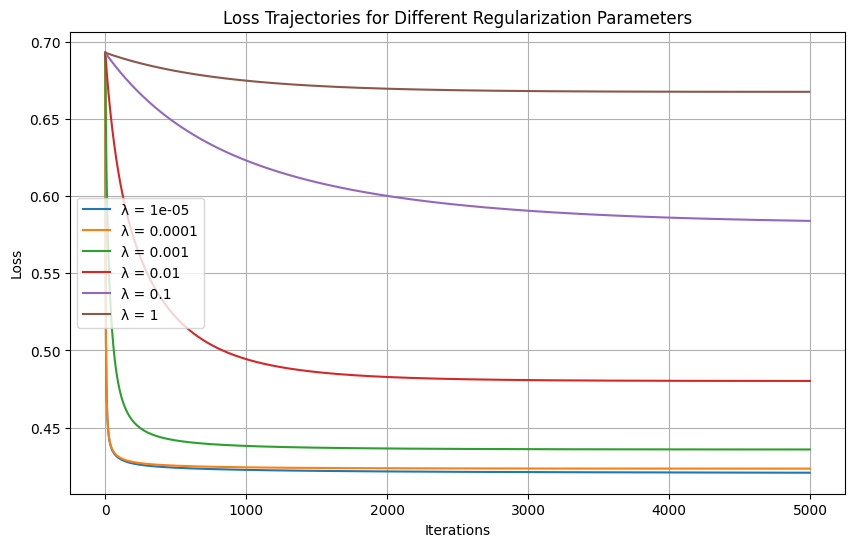

In [ ]:
def plot_loss_trajectories(results):
    plt.figure(figsize=(10, 6))

    for result in results:
        reg_param = result['reg_param']
        losses = result['losses']
        plt.plot(losses, label=f'λ = {reg_param}')

    plt.title('Loss Trajectories for Different Regularization Parameters')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_trajectories(results_L2)

### 1.1 Impact on training and validation accuracy

Plot the training accuracy and validation accuracy of the learned L2 regularized logistic regression model as a function of $\lambda$.
When plotting, use a logarithmic scale for the x-axis to represent $\lambda$. In other words, each tick mark on the x-axis should correspond to a unique integar $i$ and be labeled as $10^{-i}$. This will allow us to better visualize how the model performance changes across different orders of magnitude for $\lambda$.  

Please plot the two curves in the same figure using different colors for easy comparison. Provide clear legend to indicate which curve is which.

In [ ]:
# Your code goes here

In [ ]:
def plot_accuracy(results):
  lambdas = []
  train_acc = []
  val_acc = []

  for i in range(len(results)):
    lambdas.append(results[i]['reg_param'])
    train_acc.append(results[i]['train_accuracy'])
    val_acc.append(results[i]['val_accuracy'])

  plt.figure(figsize=(10,6))
  plt.plot(lambdas, train_acc, label='Training Accuracy', color='blue', marker='o')
  plt.plot(lambdas, val_acc, label='Validation Accuracy', color='red', marker='o')

  plt.xscale('log')

  plt.xlabel(r'$\lambda$ (log scale)')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy vs. Regularization parameters')

  plt.grid(True)
  plt.legend()
  plt.show()

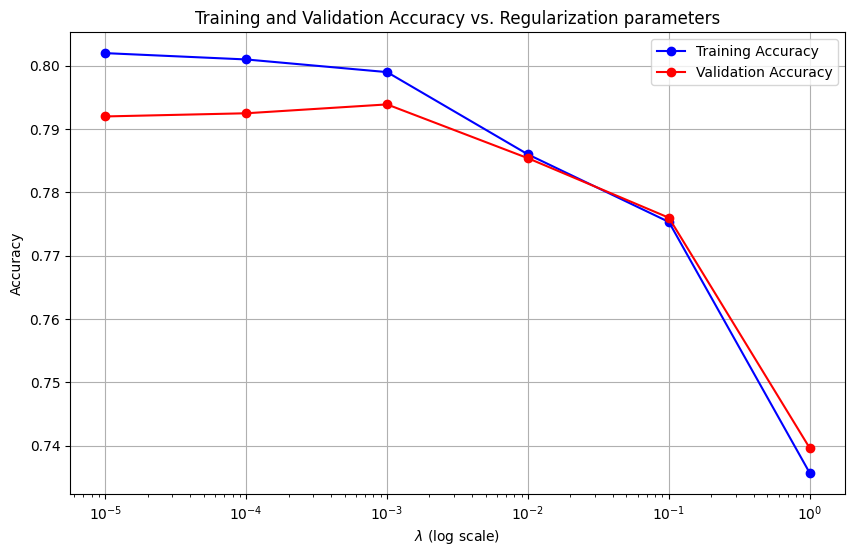

In [ ]:
plot_accuracy(results_L2)

**Question**

(a) Which $\lambda$ value leads to the best training and validation accuracy respectively? Which one should you use if you are to pick a model for deployment?

(b) What trend do you observe for the training and validation accuracy respectively as we increae $\lambda$? Provide your explanation for this observed trend.


**Your answer goes here**

(a)
As observed in the plot:
- Best training accuracy occurs at λ = 1e-05 with a training accuracy of 0.8020.
- Best validation accuracy occurs at λ = 0.001 with a validation accuracy of 0.7939.

For deployment, validation accuracy is more important since it reflects the model's performance on unseen data. Therefore, the model with λ = 0.001 (which has a validation accuracy of 0.7939) is likely to be the best choice for deployment.

(b) As we increase the regularization parameter, both training accuracy and validation accuracy decreases.

- Training accuracy decreases: Higher values of λ penalize the complexity of the model, reducing its ability to fit the training data. This leads to underfitting as the model becomes simpler which makes model less likely to capture the complexities of the training data.
- Validation accuracy decreases, but less steeply: A small amount of regularization can help with generalization, but as λ increases too much, the model underfits, reducing its ability to generalize to new data.


###1.2 Impact on feature weights
For each value of $\lambda$, present the top five features based on the magnitude of their weights $|w_j|$, excluding the bias term $w_0$. Organize your results into a table. Each column should be dedicated to a specific $\lambda$ value, and rows should indicate the rank of the feature. Ensure that each cell in the table contains both the feature name and its corresponding weight $w_j$.

For example:

| Rank  | $\lambda = 10^{-4}$      | $\lambda = 10^{-3}$      | $\lambda = 10^{-2}$      |
|-------|--------------------------|--------------------------|--------------------------|
| 1     | feature_a, 0.8           | feature_b, 0.7           | feature_c, 0.6           |
| 2     | feature_d, 0.7           | feature_e, 0.6           | feature_f, 0.5           |
| 3     | feature_g, 0.6           | feature_h, 0.5           | feature_i, 0.4           |
| 4     | feature_j, 0.5           | feature_k, 0.4           | feature_l, 0.3           |
| 5     | feature_m, 0.4           | feature_n, 0.3           | feature_o, 0.2           |

The easiest way is to create a dataframe for this table and print the dataframe.

In [ ]:
#Your code goes here
weigths = results_L2[0]['weight']

In [ ]:
# Find top 5 values for each value of lambda
set_top_5 = []
for i in range(len(results_L2)):
  weights = results_L2[i]['weight']
  sorted_abs_w = sorted(np.abs(weights[1:]))
  top_5_values = sorted_abs_w[-5:][::-1]
  top_5_features_values = []

  # Find index
  for j in range(5):
    idx = np.where(np.abs(weights)==top_5_values[j])[0][0]

    # Except dummy case
    if idx == 0:
      idx = np.where(np.abs(weights)==top_5_values[j])[0][1]

    top_5_features_values.append((x_train.columns[idx], weights[idx]))
  set_top_5.append(top_5_features_values)

set_top_5

# Show a table of top 5 values in each lambdas

# Regularization parameters
lambdas = [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1]

# Create empty dataframe
df = pd.DataFrame()

# Make a table
for i, lam in enumerate(lambdas):
  df[f'λ={lam}'] = set_top_5[i]

# Insert 'Rank' index at front
df.insert(0, 'Rank', [1, 2, 3, 4, 5])
df

,Rank,λ=1e-06,λ=1e-05,λ=0.0001,λ=0.001,λ=0.01,λ=0.1
0,1,"(Previously_Insured, -3.2717422855344886)","(Previously_Insured, -3.1631977990156668)","(Previously_Insured, -2.6012382252015542)","(Previously_Insured, -1.583392472067516)","(Previously_Insured, -0.54229224482258)","(Previously_Insured, -0.10862142883502773)"
1,2,"(Vehicle_Damage, 2.2930975925084778)","(Vehicle_Damage, 2.2728797325082155)","(Vehicle_Damage, 2.1122207446608043)","(Vehicle_Damage, 1.466509705920589)","(Vehicle_Damage, 0.4992444741150132)","(Vehicle_Damage, 0.10480711490741629)"
2,3,"(Policy_Sales_Channel_160, -1.8806523641886927)","(Policy_Sales_Channel_160, -1.8065283052308074)","(Policy_Sales_Channel_160, -1.3575672918209423)","(Policy_Sales_Channel_152, -0.5453702395837156)","(Policy_Sales_Channel_152, -0.24666121975480573)","(Vehicle_Age_1, -0.061378289670364745)"
3,4,"(Policy_Sales_Channel_16, -1.8761210369067742)","(Policy_Sales_Channel_16, -1.4280523135117538)","(Policy_Sales_Channel_152, -0.7642273391470842)","(Vehicle_Age_1, -0.49536611436416617)","(Vehicle_Age_1, -0.23622970591567036)","(Policy_Sales_Channel_152, -0.05977984083775971)"
4,5,"(Region_Code_34, 1.3609559159740021)","(Region_Code_34, 1.1272249047255776)","(Region_Code_3, 0.6057438573133472)","(Policy_Sales_Channel_160, -0.40298378467186285)","(Vehicle_Age_0, 0.09634126411895455)","(Age, 0.05320425872614368)"


**Question**

1. Do you observe any difference is the top features with different $\lambda$ values?
2. Do you observe any difference in the weights of the top features for different $\lambda$ values?
3. Please provide your own explanation/interpretation of the observed differences.

**Your answer goes here**


1. Across all regularization parameter, "Previously_Insured" and "Vehicle_Damage" feature keeps top 2 rank.
However, as the $\lambda$ increases, the list of rest features that are ranked 3-5 changes slightly. For lower values of $\lambda$ $10^{-5}$ and $10^{-3}$, the features "Region_Code_2", "Policy_Sales_Channel_16" and "Policy_Sales_Channel_160" consistently have the highest weights. However, as $\lambda$ increases, new features like "Vehicle_Age_1", "Policy_Sales_Channel_152", and "Age" emerged in the top list, and some previous feature such as "Policy_Sales_Channel_160" has reduced significance.

2. The absolute values of weights for the top features decrease as $\lambda$ increases. For instance, "Previously_Insured" has a weight of -3.27 at $\lambda$ = $10^{-5}$ but reduces to -0.11 when $\lambda$ = 1. This trend is consistent across all features, indicating that larger $\lambda$ values pull the weights closer to zero.

3. Regularization penalizes large coefficients, effectively shrinking feature weights towards zero as $\lambda$ increases. This behavior reduces the model's dependence on individual features, aiming to prevent overfitting by limiting the influence of features that might capture noise or specific patterns in the training data. At low $\lambda$ values, the model prioritizes a few features with large weights, which could lead to overfitting. As $\lambda$ increases, the model begins to balance the contributions of more features with smaller weights, resulting in a more generalized representation.


###1.3 sparsity of weights

For each different value of $\lambda$, compute the sparsity of the learned classifier as the number of feature weights that approxmately equal zero ($\leq 10^{-6}$) and report the sparsity number for each $\lambda$ value.

In [ ]:
# Your code goes here

In [ ]:
# Define threshold for sparsity
threshold = 10**-6

# Compute sparsity for each lambda value
sparsity = {}

# Loop through each result in results list
for result in results_L2:
    reg_param = result['reg_param']
    weights = result['weight']

    # Count the number of weights approximately equal to zero
    zero_count = np.sum(np.abs(weights) <= threshold)
    sparsity[reg_param] = zero_count

df = pd.DataFrame(list(sparsity.items()), columns=['λ', 'Sparsity'])
df

,λ,Sparsity
0,0.00001,47
1,0.00010,47
2,0.00100,47
3,0.01000,47
4,0.10000,47
5,1.00000,48


**Question**

1. When we have very small $\lambda$ values (aka very weak regularization), does your learned model have zero weights for some features?  If so, why would it be that way?
2. What trend do you observe for the sparsity of the model as we increase $\lambda$? If we further increase $\lambda$ to even larger values, what do you expect to happen to the sparsity value? Why?


**Your answer goes here**

1. As $\lambda$ increases, the regularization effect grows stronger, penalizing larger weights more heavily and pushing many weights closer to zero. This results in a gradual increase in sparsity as shown in the previous table wher sparsity increased to 48 when $\lambda$ is 1.

2. If we continue to increase $\lambda$ to even larger values, the model will push more feature weights to zero, further increasing sparsity. In the extreme case with a very large $\lambda$, almost all feature weights could be driven to zero. This happens since in regularized models, we add a penalty term to the loss function that is proportional to the magnitude of feature weights. When we increase $\lambda$, this penalty term becomes more substantial. This penalty encourages the model to keep weights small, as larger weights incur a larger penalty. The regularization penalty acts like a "cost" on non-zero weights. With a higher $\lambda$, the model finds it "cheaper" (in terms of minimizing the loss function) to set more weights to zero than to keep non-zero weights and incur the increased penalty. With higher regularization, the model becomes more willing to discard features entirely, assigning them zero weight to avoid the penalty.

# Part 2. (40 pts) Logistic regression with L1 regularization.

In this part, we will repeat the part 1 but with L1 regularization. Please refer to the algorithm 2 in the Assignment 2 Reference Information file for the details of the algorithm.

## Impelement Logistic regression with L1 regularization
As a recommendation, your implemented function should consider the following inputs:
1. The training data
2. The regularization parameter $\lambda$
3. The learning rate
4. Max iterations (recommend to start with 5000)
5. Threshold for change in loss (this will be used for early stopping: if the change in loss is less than the threshold, it is considered to have converged. Please use a threshold of $10^{-7}$. )

Your function should output the learned weight vector. But it is also a good idea to output the sequence of losses so that you can visualize the convergence process.
You should also implement a divergence detection, if the loss starts to diverge, terminate and raise an alarm.


In [ ]:
# Your code goes here.

In [ ]:
#Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

#Loss function
def calculate_loss_L1(X,y, weight,regularization_param):
  N, d = X.shape
  y_pred = sigmoid(np.dot(X, weight))

  loss = -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
  reg_loss = (regularization_param) * np.sum(np.abs(weight))

  return loss + reg_loss

In [ ]:
# Logistic Regression

def logistic_regression_L1(X, y, learning_rate, regualrization_para, max_iterations, threshold):
  N, d = X.shape
  weight = np.zeros(d)
  losses = []
  divergence_threshold = 100
  check_convergence = False

  # Gradient descent loop
  for it in range(max_iterations):
    # Caculate the gradient
    y_pred = sigmoid(np.dot(X, weight))
    gradient = np.dot(X.T, (y - y_pred)) / N

    # L1 norm
    new_weight = weight + learning_rate * gradient
    for j in range(d):
      new_weight[j] = np.sign(new_weight[j]) * max(np.abs(new_weight[j]) - learning_rate * regualrization_para, 0)

    # Calculate the loss
    loss = calculate_loss_L1(X, y, weight, regualrization_para)
    losses.append(loss)

    # Adjust learning rate based on loss behavior
    if it > 2:
      loss_diff = losses[-2] - losses[-1]

      # Check for divergence
      if loss_diff < 0:
        divergence_threshold -= 1

      # Stop if loss diverges too much
      if divergence_threshold == 0:
        print("Loss diverged too many times. Stopping.")
        break

    if np.linalg.norm(new_weight - weight) < threshold:
      check_convergence = True
      print(f"Converged after {it + 1} iterations.")
      break

    weight = new_weight

  return weight, losses, check_convergence

##Experiment with different regularization parameters
For this part, you will need to run your L1 logistic regression algorithm on the training data with different regularization parameters $\lambda\in \{10^i: i\in[-6, -1]\}$. You are welcome to experiment with more extreme or in-between values to help you answer the questions. But be advised using larger $\lambda$ values in this case makes it difficult to converge.

**Learning Rate Tuning Guidelines:**
For L1 regularization, I recommend starting with $\gamma = 2$ for very small $\lambda$s like $10^{-6}, 10^{-5}$, and decreasing the learning for larger $\lambda$ values.

For each $\lambda$ value, you are required to run L1 logistic regression to convergence, record the resulting model (weights), evaluate it on the training and validation data, and record the accuracies.

In [ ]:
# Your code goes here

In [ ]:
x_train = norm_train.drop('Response', axis=1)
y_train = norm_train['Response']
x_val = norm_val.drop('Response', axis=1)
y_val = norm_val['Response']

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

def run_logistic_regression_L1(X_train, y_train, X_val, y_val, learning_rates, regularization_params):
    results = []

    for i, reg_param in enumerate(regularization_params):
        learning_rate = learning_rates[i]

        # Train the model
        weight, losses, check_convergence = logistic_regression_L1(X_train, y_train, learning_rate, reg_param, max_iterations=5000, threshold=1e-7)

        # Training accuracy
        y_train_pred = sigmoid(np.dot(X_train, weight)) >= 0.5
        train_accuracy = accuracy_score(y_train, y_train_pred)

        # Validation accuracy
        y_val_pred = sigmoid(np.dot(X_val, weight)) >= 0.5
        val_accuracy = accuracy_score(y_val, y_val_pred)

        # Store the results
        results.append({
            'reg_param': reg_param,
            'learning_rate': learning_rate,
            'train_accuracy': train_accuracy,
            'val_accuracy': val_accuracy,
            'weight': weight,
            'losses': losses
        })

        # Check if the model has converged
        if check_convergence:
          print("Converged")

        print(f"learning_rate:{learning_rate}, reg_param = {reg_param}, Training accuracy = {train_accuracy:.4f}, Validation accuracy = {val_accuracy:.4f}")

    return results

regularization_params = [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1]
learning_rates = [2, 2, 2, 0.5, 0.1, 0.005]

results = run_logistic_regression_L1(x_train, y_train, x_val, y_val, learning_rates, regularization_params)

learning_rate:2, reg_param = 1e-06, Training accuracy = 0.8023, Validation accuracy = 0.7915
learning_rate:2, reg_param = 1e-05, Training accuracy = 0.8018, Validation accuracy = 0.7921
learning_rate:2, reg_param = 0.0001, Training accuracy = 0.8008, Validation accuracy = 0.7929
learning_rate:0.5, reg_param = 0.001, Training accuracy = 0.7917, Validation accuracy = 0.7910
learning_rate:0.1, reg_param = 0.01, Training accuracy = 0.7825, Validation accuracy = 0.7849
learning_rate:0.005, reg_param = 0.1, Training accuracy = 0.7555, Validation accuracy = 0.7578


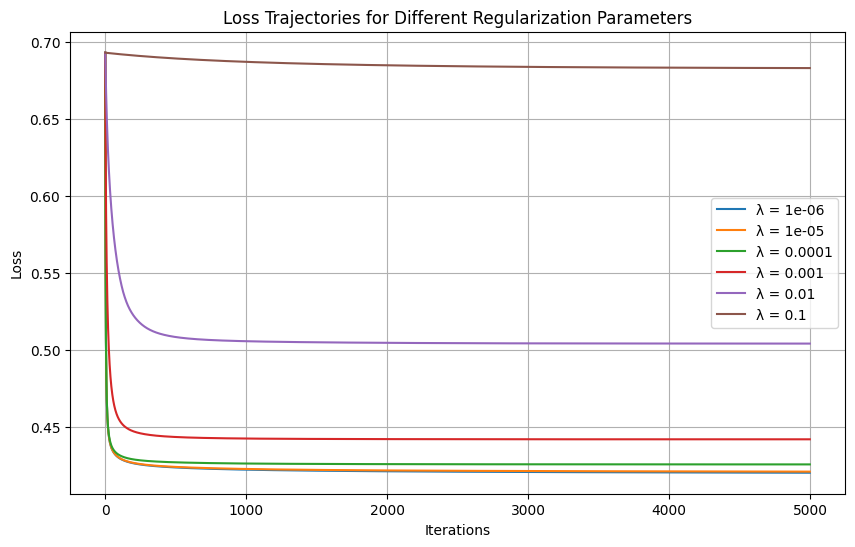

In [ ]:
def plot_loss_trajectories(results):
    plt.figure(figsize=(10, 6))

    for result in results:
        reg_param = result['reg_param']
        losses = result['losses']

        plt.plot(losses, label=f'λ = {reg_param}')

    plt.title('Loss Trajectories for Different Regularization Parameters')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: Plot the losses for your results
plot_loss_trajectories(results)

### 2.1 Impact on training/validation accuracy, and sensitivity to regularization parameter
Plot the training accuracy and validation accuracy of the learned L1 regularized logistic regression model as a function of $\lambda$. When plotting, use a logarithmic scale for the x-axis to represent $\lambda$. In other words, each tick mark on the x-axis should correspond to a unique integar $i$ and be labeled as  $10^{−i}$ . This will allow us to better visualize how the model performance changes across different orders of magnitude for $\lambda$.

Please plot the two curves in the same figure using different colors for easy comparison. Provide clear legend to indicate which curve is which.

In [ ]:
# Your code goes here

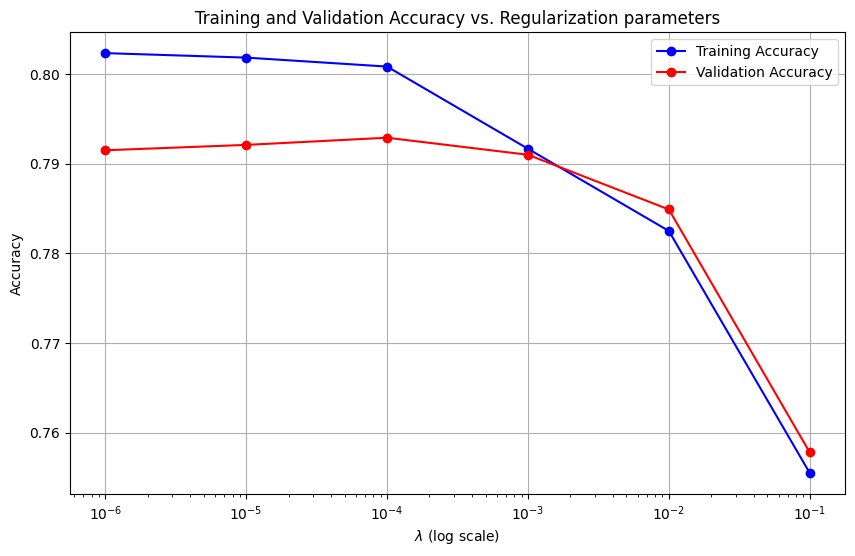

In [ ]:
lambdas = []
train_acc = []
val_acc = []

for i in range(len(results)):
  lambdas.append(results[i]['reg_param'])
  train_acc.append(results[i]['train_accuracy'])
  val_acc.append(results[i]['val_accuracy'])

plt.figure(figsize=(10,6))
plt.plot(lambdas, train_acc, label='Training Accuracy', color='blue', marker='o')
plt.plot(lambdas, val_acc, label='Validation Accuracy', color='red', marker='o')

plt.xscale('log')

plt.xlabel(r'$\lambda$ (log scale)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Regularization parameters')

plt.grid(True)
plt.legend()
plt.show()

**Question**

(a) For L1 LR, which $\lambda$ value leads to the best training and validatoin accuracy respectively? Which one should you use if you are to pick a model for deployment?

(b) What trend do you observe for the training and validation accuracy respectively as we increae $\lambda$? Provide your explanation for this observed trend.

(c) Comparing L1 and L2 regularized logistic regression, which one is more sensitive to the choice of the regularization parameter? An algorithm is considered sensitive to the regularization parameter if the model's performance or the values of its learned parameters change significantly with variations in the regularization parameter. Given that your experiments explored a smaller range of $\lambda$ values for L1 regularization due to convergence concern, you may use an off-the-shelf implementation (e.g., from scikit-learn) to explore this comparison more effectively. Reflect on the differences you observe (or expect to observe) between L1 and L2 in terms of sensitivity to the regularization parameter, and explain why.


**Your answer goes here**

(a) As observed in the plot:

- The best training accuracy occurs at $\lambda=10^{-6}$ with a training accuracy of 0.8023.
- The best validation accuracy occurs at $\lambda=10^{-4}$ with a validation accuracy of 0.7929.

For deployment, validation accuracy is more important because it reflects the model's performance on unseen data. Therefore, the model with $\lambda=10^{-4}$ (which has a validation accuracy of 0.7929) is likely to be the best choice for deployment.

(b) As we increase the regularization parameter, both training and validation accuracy decreases.

- Training accuracy decreases: Higher values of $\lambda$ penalize the complexity of the model, reducing its ability to fit the training data. This causes to underfit and be less likely to capture the complexities of the training data.
- Validation accuracy decreases, but less steeply: A small amount of regularization can help with generalization, but as $\lambda$ increases too much, the model underfits, reducing its generalization ability.

(c) L1 regularization (Lasso) is more sensitive to the choice of the regularization parameter $\lambda$ than L2 regularization (Ridge).

The parameter updates of L1 regularization tends to make some weights exactly to zero, shifting which features it retains or discards. Small changes in $λ$ can cause to significant changes in which parameters are non-zero and finally affect the model's performance more drastically, which is based on the feature selecting or ignoring. Due to these properties, the convergence become unstable for very high or low values of $λ$ (So, we may use smaller ranges).

On the other hand, L2 regularization penalizes large values of coefficients and reduces the magnitude of all parameters instead of making them exactly to zero. Since L2 regularization applies a uniform penalty, changes in $λ$ do not drastically shift feature selection, showing gradual changes in both learned parameters and performance as $λ$ varies. Based on these properties, L2 regularization provides stable optimization.

From the experiments above, we know that L1 regularization shows sharper drops with respect to the same value of $λ$, changing some weights exactly to zero. Due to selecting zero-coefficient, more features are eliminated from the model, making more sensitive than L2. However, L2 Regularization produces smoother changes in performance as $λ$ varies since it shrinks coefficients more uniformly rather than eliminating them.


###2.2 Impact on feature weights
For each value of $\lambda$, present the top five features based on the magnitude of their weights $|w_j|$, excluding the bias term $w_0$. Organize your results into a table. Each column should be dedicated to a specific $\lambda$ value, and rows should indicate the rank of the feature. Ensure that each cell in the table contains both the feature name and its corresponding weight $w_j$.

For example:

| Rank  | $\lambda = 10^{-4}$      | $\lambda = 10^{-3}$      | $\lambda = 10^{-2}$      |
|-------|--------------------------|--------------------------|--------------------------|
| 1     | feature_a, 0.8           | feature_b, 0.7           | feature_c, 0.6           |
| 2     | feature_d, 0.7           | feature_e, 0.6           | feature_f, 0.5           |
| 3     | feature_g, 0.6           | feature_h, 0.5           | feature_i, 0.4           |
| 4     | feature_j, 0.5           | feature_k, 0.4           | feature_l, 0.3           |
| 5     | feature_m, 0.4           | feature_n, 0.3           | feature_o, 0.2           |

In [ ]:
# Your code goes here

In [ ]:
# Find top 5 values for each value of lambda
set_top_5 = []
for i in range(len(results)):
  weights = results[i]['weight']
  sorted_abs_w = sorted(np.abs(weights[1:]))
  top_5_values = sorted_abs_w[-5:][::-1]
  top_5_features_values = []

  # Find index
  for j in range(5):
    idx = np.where(np.abs(weights)==top_5_values[j])[0][0]

    # Except dummy case
    if idx == 0:
      idx = np.where(np.abs(weights)==top_5_values[j])[0][1]

    top_5_features_values.append((x_train.columns[idx], weights[idx]))
  set_top_5.append(top_5_features_values)

In [ ]:
# Show a table of top 5 values in each lambdas

# Regularization parameters
lambdas = [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1]

# Create empty dataframe
df = pd.DataFrame()

# Make a table
for i, lam in enumerate(lambdas):
  df[f'λ={lam}'] = set_top_5[i]

# Insert 'Rank' index at front
df.insert(0, 'Rank', [1, 2, 3, 4, 5])
df

,Rank,λ=1e-06,λ=1e-05,λ=0.0001,λ=0.001,λ=0.01,λ=0.1
0,1,"(Previously_Insured, -3.284652679326412)","(Previously_Insured, -3.280571091276429)","(Previously_Insured, -3.2440366507848406)","(Previously_Insured, -3.0362973952599646)","(Previously_Insured, -2.5483070513047212)","(Previously_Insured, -0.37651538686585007)"
1,2,"(Vehicle_Damage, 2.2955643773934447)","(Vehicle_Damage, 2.2923606026478427)","(Vehicle_Damage, 2.2610796210496753)","(Vehicle_Damage, 2.054055037043019)","(Vehicle_Damage, 1.0273481439211476)","(Vehicle_Damage, 0.19100339003471406)"
2,3,"(Policy_Sales_Channel_16, -1.9404273142137307)","(Policy_Sales_Channel_16, -1.9114972273531416)","(Policy_Sales_Channel_160, -1.9310195315852887)","(Policy_Sales_Channel_160, -1.679575771147528)","(Vehicle_Age_1, -0.42292944801746074)","(Gender, 0.0)"
3,4,"(Policy_Sales_Channel_160, -1.8904414877348266)","(Policy_Sales_Channel_160, -1.9001104206849055)","(Policy_Sales_Channel_16, -1.6215074992511649)","(Policy_Sales_Channel_152, -0.9569807740811186)","(Policy_Sales_Channel_152, -0.3949264643911322)","(Gender, 0.0)"
4,5,"(Region_Code_34, 1.3915715833138511)","(Region_Code_34, 1.3684328324525814)","(Region_Code_34, 1.1612677145000605)","(Region_Code_3, 0.4948528220959412)","(Age, -0.055877238918576586)","(Gender, 0.0)"


**Question**

1. Do you observe any difference is the top features with different $\lambda$ values?
2. Do you observe any difference in the weights of the top features for different $\lambda$ values?
3. Please provide your own explanation/interpretation of the observed differences.
4. What are some differences for this part of the results comparing L1 and L2 regularization? Provide your own explanation for such differences.


**Your answer goes here**

1. Differences in features
- `Previously_Insured` and `Vehicle_Damage` consistently appear among the top five features across most $λ$ values. This indicates that they are strong predictors for the model regardless of regularization.

- Some other features like `Policy_Sales_Channel_16' `and`  'Policy_Sales_Channel_160` appears in the top features for certain $λ$ values but not for others. For instance, `Vehicle_Age_1` and `Gender` only appear $λ=0.01$ and $λ=0.1$ respectively.

2. Differences in weights
- The weights associated with the top features vary significantly with different $λ$ values. For example, the weight for `Previoously_Insured` decreases from -3.2846 ($\lambda=10^{-6}$) to -0.37651 ($\lambda=10^{-1}$). This indicates that higher regularization penalizes the weights.

- Some weights increase with increasing $λ$, as seen with `Policy_Sales_Channel_16` and` Policy_Sales_Channel_160`, whose weight go from -1.9404 and -1.8904 (both $λ=10^{-6}$) to -1.6795 and -0.9569 (both $λ=10^{-3}$) respectively.

3. Explanation/interpretation of the observed differences
- As $λ$ increases, the set of top features changes. `Previously_Insured` and `Vehicle_Damage` remain as the most important features throughout, but other features like `Policy_Sales_Channel_16`, `Policy_Sales_Channel_160`, are gradually replaced by features like `Vehicle_Age_1`, and `Gender`. The introduction of $λ=0.1$ significantly changes the selected features, with some features' weights reduced to zero, reflecting L1 regularization's ability to encourage sparsity.

- For small values of $λ$, such as $λ=10^{-6}$ and $λ=10^{-5}$, the weights of features are generally higher in magnitude. As $λ$ increases, the magnitude of feature weights decreases. This implies that larger values of $λ$ apply strong penalties to the weights, preventing the model from overfitting.

- From the empirical data above, the model complexity reduces when $λ$ increases, and the magnitude of coefficients is penalized by pushing less important features towards zero. As smaller values of $λ$ is applied, the model is more complex, possibly leading to overfitting on the training data. For larger $λ$, the regularization helps in reducing overfitting by simplifying the model.     

4. Comparison between L1 and L2 regularization and explanation of differeneces

- When it comes to weight shrinking, L1 regularization has the effect of shrinking some weights to exactly to zero as $λ$ increases. This can be observed as many features drop out of the top feature list, resulting in sparse solutions where only the most relevant features are retained. L2 regularization, on the other hand, shrinks all weights proportionally without making them zero, resulting in a model where all features still have some influence, though reduced by regularization.

- In terms of the sensitivity to regularization parameter $λ$, L1 is more sensitive to changes in $λ$ whereas L2 shows more gradual changes. The characteristic of L1's tend to produce sparse models where most relevant features are kept. L2 tends to include all features without discarding, but reduce their influence to prevent overfitting.

- The model complexity of L1 regularization is different from the one of L2. L1 focuses more on simplifying the model by eliminating features with small contributions. However, as the experiment shows, the downside of L1 regularization is that it may eliminate too many features if $λ$ is not carefully tuned. In contrast, L2 maintains all features while reducing their influence, making it less sensitive and more stable compared to L1.

###2.3 Sparsity of weights

For each different value of $\lambda$, compute the sparsity of the learned L1 regularized logistic regression classifier as the number of feature weights that approxmately equal zero ($\leq 10^{-6}$) and report the sparsity number for each $\lambda$ value.

In [ ]:
# Your code goes here

In [ ]:
# Define threshold for sparsity
threshold = 10**-6

# Compute sparsity for each lambda value
sparsity = {}

# Loop through each result in results list
for result in results:
    reg_param = result['reg_param']
    weights = result['weight']

    # Count the number of weights approximately equal to zero
    zero_count = np.sum(np.abs(weights) <= threshold)
    sparsity[reg_param] = zero_count

df = pd.DataFrame(list(sparsity.items()), columns=['λ', 'Sparsity'])
df

,λ,Sparsity
0,0.000001,50
1,0.000010,59
2,0.000100,119
3,0.001000,170
4,0.010000,190
5,0.100000,195


**Question**

1. What trend do you observe for the sparsity of the L1 regularized model as we change $\lambda$? If we further increase $\lambda$, what do you expect? Why?
2. What are some differences for this part of the results comparing L1 and L2 regularization? Provide your own explanation for such differences.


**Your answer goes here**

1. Trend of the sparsity of the L1 regularized model
- As $λ$ increases, the penality term becomes stronger, forcing less important coefficients towards zero. Due to this, the number of zero increases, leading to sparse. If we further increase $λ$, the model will underfit and show lower training and validation accuracy since the weights of many features have a value of zero. At the end, there are no or only a few features influence the model, producing unreliable prediction.

2. Comparing L1 regularization with L2 in terms of sparsity
- As $λ$ increases, L1 and L2 show different results of the sparsity. The number of zero in the weights of L1 regularization increase drastically. The case of $λ=0.1$ provides over 190 zero in most features. Contrarily, L2 has the smaller number of zero than L1, showing the most features engages in the model.

- From the experiment data, the sensitivity to regularization parameter $\lambda$ implies that L1 is more sensitive than L2 since the number of zero increases drastically as $λ$ increases. L2 is less sensitive and provides gradual differences of the number of zero.

- The L1 penalty term is defined as the sum of absolute value of each weight, resulting in an optimization with sharp edges at zero. On the other hand, the L2 penalty term is defined as the sum of the square of each weight, creating a smooth parabolic shape.    

# Part 3. (25 pts) Impact of Noise
For this part, you will be training both L1 and L2 logistic regression models using the noisy training data. For L2, you should consider the same set of $\lambda$ values as part 1. For L1, you will find it to be extremely difficult to converge to a meaningful solution for $\lambda=0.1$, so you will use the same set of values as part 2 but exclude $\lambda=0.1$.  For each regularization method, please plot the model's training and validation accuracy against the regularization parameter $\lambda$.

In [ ]:
# Your code goes here

In [ ]:
x_train_noisy = norm_nosiy.drop('Response', axis=1)
y_train_noisy = norm_nosiy['Response']
x_val = norm_val.drop('Response', axis=1)
y_val = norm_val['Response']

In [ ]:
#L2
regularization_params_L2 = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1]
learning_rates_L2 = [2, 2, 0.2, 0.02,0.002,0.0005]

results_noisy_L2 = run_logistic_regression_L2(x_train_noisy, y_train_noisy, x_val, y_val, learning_rates, regularization_params)

learning_rate:2, reg_param = 1e-06, Training accuracy = 0.6242, Validation accuracy = 0.7774
learning_rate:2, reg_param = 1e-05, Training accuracy = 0.6238, Validation accuracy = 0.7775
learning_rate:2, reg_param = 0.0001, Training accuracy = 0.6240, Validation accuracy = 0.7792
learning_rate:0.5, reg_param = 0.001, Training accuracy = 0.6183, Validation accuracy = 0.7866
learning_rate:0.1, reg_param = 0.01, Training accuracy = 0.6122, Validation accuracy = 0.7874
learning_rate:0.005, reg_param = 0.1, Training accuracy = 0.6080, Validation accuracy = 0.7792


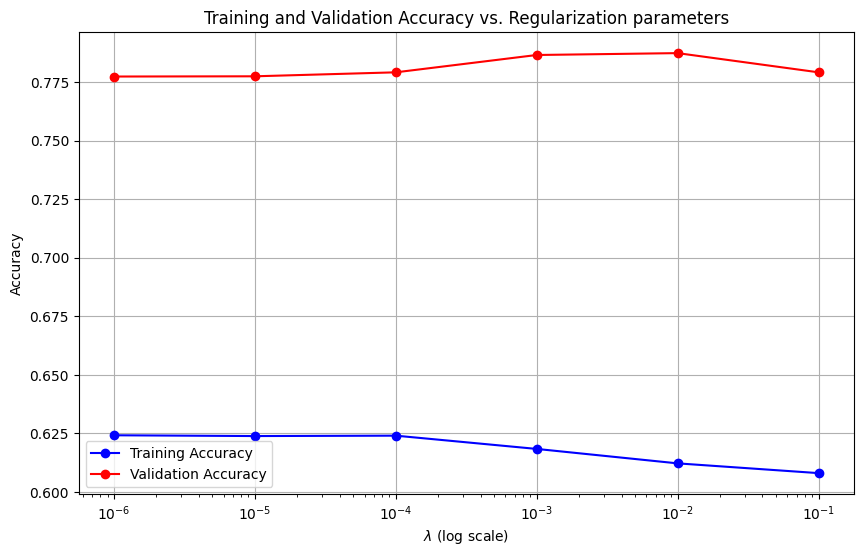

In [ ]:
plot_accuracy(results_noisy_L2)

In [ ]:
#L1
regularization_params_L1 = [10**-6, 10**-5, 10**-4, 10**-3,10**-1]
learning_rates_L1 = [2, 2, 2, 0.5,0.005]

results_noisy_L1 = run_logistic_regression_L1(x_train_noisy, y_train_noisy, x_val, y_val, learning_rates, regularization_params)

learning_rate:2, reg_param = 1e-06, Training accuracy = 0.6242, Validation accuracy = 0.7774
learning_rate:2, reg_param = 1e-05, Training accuracy = 0.6240, Validation accuracy = 0.7781
learning_rate:2, reg_param = 0.0001, Training accuracy = 0.6202, Validation accuracy = 0.7795
learning_rate:0.5, reg_param = 0.001, Training accuracy = 0.6113, Validation accuracy = 0.7877
Converged after 3021 iterations.
Converged
learning_rate:0.1, reg_param = 0.01, Training accuracy = 0.6062, Validation accuracy = 0.7713
Converged after 1 iterations.
Converged
learning_rate:0.005, reg_param = 0.1, Training accuracy = 0.4958, Validation accuracy = 0.4934


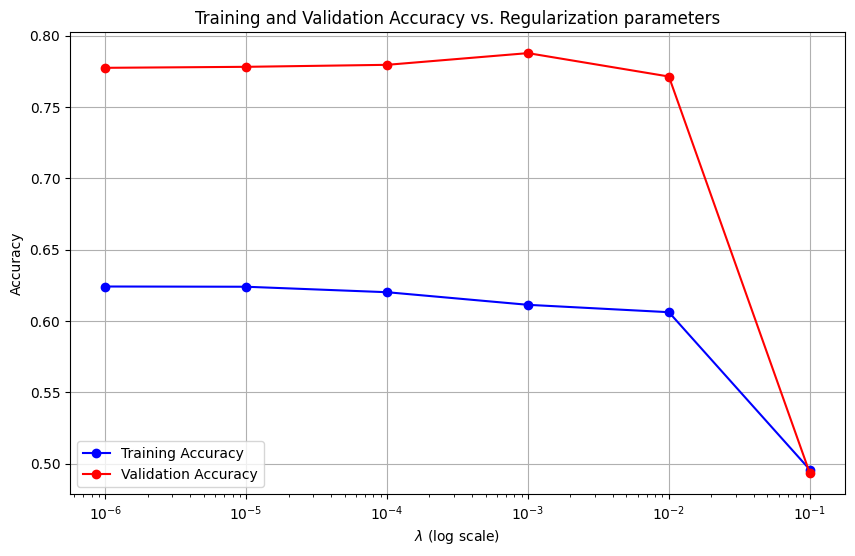

In [ ]:
plot_accuracy(results_noisy_L1)

**Question**
Your experiments should reveal that when trained with the noisy data, both L1 and L2 regulated logistic regression models would have substantially reduced training accuracies, but the validation accuracies will only suffer a mild reduction.  

Here I provide two possible explanations for this phenonmenon:
1. This is due to the use of regularization, which reduces the model's ability to overfit to the noise.
2. This is due to the simplicity of the model, which just could not overfit to the noise very well.

For this case, what do you think is the main cause for the observe phenomenon? Why?

Please design another experiment that will allow you to figure out which of the two possibilities plays a more critical role in the observed phenomenon. **You do not need to run this experiment**, just need to explain the experiment and why it would help answer the question.


**Your answer goes here.**

The main cause of the observed phenomenon is likely due to the use of regularization, which reduces the model's ability to overfit to the noise. Regularization techniques, such as $L_1$and $L_2$, constrain the model complexity, preventing it from fitting random fluctuations in the noisy training data. This results in reduced training accuracy but relatively stable validation accuracy, as the model focuses on capturing the underlying patterns rather than the noise.


1. **Experiment Setup**:
   - **Dataset**: Use the same noisy dataset as before.
   - **Models**: Train four models:
     1. Logistic Regression without Regularization
     2. Logistic Regression with Regularization (both L1 and L2 regularization).
     3. Complex Model without Regularization (such as neural network with multiple layers).
     4. Complex Model with Regularization(both L1 and L2 regularization).

2. **Evaluation**:
   - Measure the training and validation accuracies of each model.
   - Observe how the regularization impacts both simple and complex models in terms of training accuracy and validation accuracy.

3. **Analysis**:
   - If regularization is the key factor in preventing overfitting, then the regularized logistic regression and the regularized complex model should both show reduced training accuracy compared to their non-regularized model, but relatively stable validation accuracy.
   - If model simplicity is the primary cause, the simple logistic regression model (without regularization) should still have reduced training accuracy compared to the complex model, while both models might overfit the noise to a similar degree since there is no regularization.

This experiment helps isolate the effect of model complexity from the effect of regularization. By comparing regularized vs. non-regularized versions of both simple and complex models, we can observe how much each regularization or model simplicity to the model's ability to generalize well on noisy data without overfitting.

# **Bonus. In-class competition (6 bonus pts)**
We will host a in-class competition using the IA2 data. For this competition, you are required to use logistic regression models. To improve your model, you can work on feature engineering (manipulating and changing the features), hyperparameter tuning, different regulerization methods. You could even use off the shelf logistic regression implementations if your own implementation is not efficient.

To participate in this competition, use the following link:
https://www.kaggle.com/t/04f96acd9e764682aaa56cef35830670

You should continue working in the same team for this competition. The training and validation data provided on the kaggle site are the same as the IA2 assignment. To participate, you will need to train your model and apply the trained to the test data provided on kaggle, and submit prediction files to be scored.

Your scoring will have two parts, the performance on the public leader board as well as the private leader board. The results on the public leader board is visible through out the competition so that you can gauge how well your model is performing in comparison to others. The private leader board shows the final evaluation performance and will be released only once after the competition is closed.

Each team will be allowed to submit 3 final entries to be evaluated. You can use the public leaderboard performance to pick which models to use for your final evaluation entries.

Assginment of the bonus points:

Performance bonus: the top 3 teams on the private leader board will recieve 6 bonus points.

Participation bonus: the 3 teams that submitted the most entries (with different performances) will recieve 4.5 bonus points.

Also any team that participated the competition and got non-trivial performance (public leaderboard score >0.78) will receive 3 bonus points.

Bonus points are capped at 6.

**Please provide the team name on the kaggle competition here _____. Leave it blank if you opt not to participate.**

In [223]:
#running this code block will convert this notebook and its outputs into a pdf report.
!jupyter nbconvert --to html /content/gdrive/MyDrive/AI534/lab2/IA2-2024.ipynb  # you might need to change this path to appropriate value to location your copy of the IA0 notebook

input_html = '/content/gdrive/MyDrive/AI534/lab2/IA2-2024.html' #you might need to change this path accordingly
output_pdf = '/content/gdrive/MyDrive/AI534/lab2/IA2output.pdf' #you might need to change this path or name accordingly

# Convert HTML to PDF
pdfkit.from_file(input_html, output_pdf)

# Download the generated PDF
files.download(output_pdf)

[NbConvertApp] Converting notebook /content/gdrive/MyDrive/AI534/lab2/IA2-2024.ipynb to html
[NbConvertApp] Writing 1129846 bytes to /content/gdrive/MyDrive/AI534/lab2/IA2-2024.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>